<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter04/Cats_Vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
from pathlib import Path

DATA_DIR = Path.home() / "data"

device = (
  "cuda"
  if torch.cuda.is_available()
  # else "mps"
  # if torch.backends.mps.is_available()
  else "cpu"
)
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from glob import glob

# %pip install torchsummary

In [2]:
%pip install -q kaggle

Note: you may need to restart the kernel to use updated packages.


Visit the file [Obtaining kaggle.json.pdf](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter04/Obtaining%20kaggle.json.pdf) on how to download `kaggle.json` file


In [3]:
# from google.colab import files

# files.upload()

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# # !chmod 600 /root/.kaggle/kaggle.json

In [5]:
# !mkdir -p ~/data/tongpython/cat-and-dog
# !pushd ~/data/tongpython/cat-and-dog
# !kaggle datasets download -d tongpython/cat-and-dog
# !ls
# !unzip cat-and-dog.zip
# !popd

In [6]:
train_data_dir = str(DATA_DIR / "tongpython/cat-and-dog/training_set/training_set")
test_data_dir = str(DATA_DIR / "tongpython/cat-and-dog/test_set/test_set")
print("train_data_dir", train_data_dir)
print("test_data_dir", test_data_dir)

train_data_dir /Users/yangjing/data/tongpython/cat-and-dog/training_set/training_set
test_data_dir /Users/yangjing/data/tongpython/cat-and-dog/test_set/test_set


In [7]:
from torch.utils.data import DataLoader, Dataset
import glob
import cv2
import torch


class cats_dogs(Dataset):
  """
  定义一个继承自Dataset的类，用于处理猫和狗的图片数据集。
  该类将用于创建一个数据加载器，以便在训练和测试时高效地加载数据。
  """

  def __init__(self, folder):
    """
    该方法将收集所有猫和狗的图片路径，并将它们打乱顺序。
    同时，它还会生成一个目标数组，用于指示每张图片是猫还是狗。
    """
    # 收集所有猫和狗的图片路径
    cats = glob(folder + "/cats/*.jpg")
    dogs = glob(folder + "/dogs/*.jpg")
    self.fpaths = cats + dogs

    # 确保每次打乱的顺序都一样
    from random import shuffle, seed

    seed(10)
    shuffle(self.fpaths)

    # 生成由 1 和 0 组成的目标数组。dog=1 & cat=0
    self.targets = [fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths]

  def __len__(self):
    """
    返回数据集的大小，即图片的数量。
    """
    return len(self.fpaths)

  def __getitem__(self, ix):
    """
    根据索引ix返回对应的图片和目标。
    """
    img = self.fpaths[ix]
    target = self.targets[ix]

    # cv2.imread(img)：使用OpenCV库的imread函数读取图片文件，返回一个NumPy数组。
    # 默认情况下，OpenCV读取的图像是以BGR（蓝、绿、红）格式存储的。
    # [:, :, ::-1]：这是对NumPy数组进行切片操作，用于将BGR格式转换为RGB格式。具体来说
    # - : 表示选取所有行。
    # - : 表示选取所有列。
    # - ::-1 表示反转通道顺序，即将第3维（颜色通道）的顺序从BGR反转为RGB。
    im = cv2.imread(img)[:, :, ::-1]
    # 调整其大小
    im = cv2.resize(im, (224, 224))

    # - 归一化 im / 255: 将图像数组 im 中的像素值从 [0, 255] 范围归一化到 [0, 1] 范围
    # - 维度排列 permute(2, 0, 1): 对于形状为 (height, width, channels) 的图像张量，
    #   permute(2, 0, 1) 将其重新排列为 (channels, height, width)
    #   这是因为大多数深度学习模型（如卷积神经网络）期望输入张量的形状为 (batch_size, channels, height, width)
    return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
      [target]
    ).float().to(device)

In [8]:
data = cats_dogs(train_data_dir)
im, label = data[200]

In [9]:
len(data)

8005

tensor([1.])


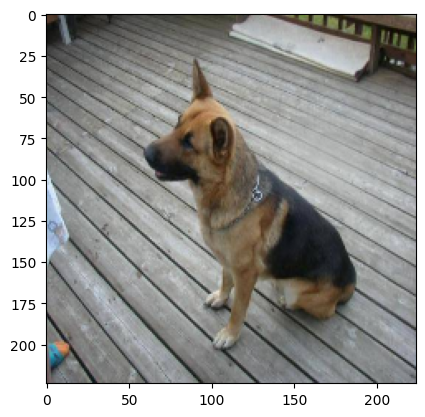

In [10]:
# im.permute 调整张量维度顺序，从 (C, H, W) 转换为 (H, W, C)，使其符合图像显示格式
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [11]:
def conv_layer(ni, no, kernel_size, stride=1):
  """
  创建一个卷积层，包含卷积、激活函数、批归一化和最大池化操作。

  参数:
  ni (int): 输入通道数。
  no (int): 输出通道数。
  kernel_size (int): 卷积核大小。
  stride (int): 卷积步长，默认为1。

  返回:
  nn.Sequential: 包含卷积、ReLU激活、批归一化和最大池化的层。
  """
  return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2),
  )


def get_model():
  """
  创建并返回一个简单的卷积神经网络模型，以及相应的损失函数和优化器。

  返回:
  model (nn.Sequential): 卷积神经网络模型。
  criterion (nn.BCELoss): 二元交叉熵损失函数。
  optimizer (torch.optim.Adam): Adam优化器。
  """
  model = nn.Sequential(
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
  ).to(device)
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [12]:
from torchsummary import summary

model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [13]:
def train_batch(x, y, model, opt, loss_fn):
  """特征 x、标签 y、模型 model、优化器 opt 和损失函数 criterion"""
  prediction = model(x)  # 预测
  batch_loss = loss_fn(prediction, y)  # 计算损失
  batch_loss.backward()  # 反向传播
  optimizer.step()  # 更新参数
  optimizer.zero_grad()  # 清空梯度
  return batch_loss.item()  # 返回损失值


@torch.no_grad()
def accuracy(x, y, model):
  """特征 x、标签 y 和模型 model"""
  prediction = model(x)  # 预测
  is_correct = (prediction > 0.5) == y  # 判断预测结果是否正确（阈值为 0.5）
  return is_correct.cpu().numpy().tolist()  # 返回预测结果

In [14]:
def get_data():
  train = cats_dogs(train_data_dir)
  # 创建训练数据加载器 trn_dl，设置批量大小为32，打乱数据并丢弃最后一个不完整的批次
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
  val = cats_dogs(test_data_dir)
  # 创建验证数据加载器 val_dl，设置批量大小为32，打乱数据并丢弃最后一个不完整的批次
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [15]:
@torch.no_grad()  # 禁用梯度计算，减少内存消耗
def val_loss(x, y, model):
  """在验证集上计算模型的损失值"""
  prediction = model(x)  # 预测
  val_loss = loss_fn(prediction, y)  # 计算损失值
  return val_loss.item()

In [16]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [19]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(1):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    # print(ix)
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
    # validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  # val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

0


In [20]:
len(train_epoch_accuracies)

8000

In [21]:
len(train_epoch_accuracies[0])

1

/var/folders/_9/xdt1l8b142z4_h7d1snnr5440000gn/T/ipykernel_44313/3361043679.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


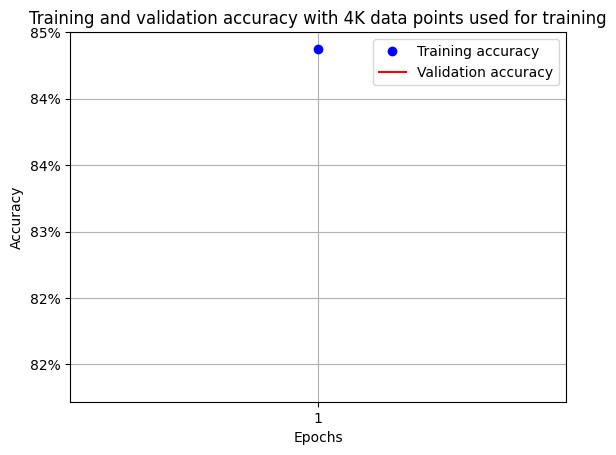

In [22]:
epochs = np.arange(1) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy with 4K data points used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

In [23]:
from torch.utils.data import DataLoader, Dataset


class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder + "/cats/*.jpg")
    dogs = glob(folder + "/dogs/*.jpg")
    self.fpaths = cats[:500] + dogs[:500]
    from random import shuffle, seed

    seed(10)
    shuffle(self.fpaths)
    self.targets = [
      fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths
    ]  # dog=1 & cat=0

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = cv2.imread(f)[:, :, ::-1]
    im = cv2.resize(im, (224, 224))
    return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
      [target]
    ).float().to(device)

In [24]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [25]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_1k = [], []
for epoch in range(2):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    # print(ix)
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
    # validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  # val_losses.append(validation_loss)
  val_accuracies_1k.append(val_epoch_accuracy)

0
1


/var/folders/_9/xdt1l8b142z4_h7d1snnr5440000gn/T/ipykernel_44313/3755882490.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


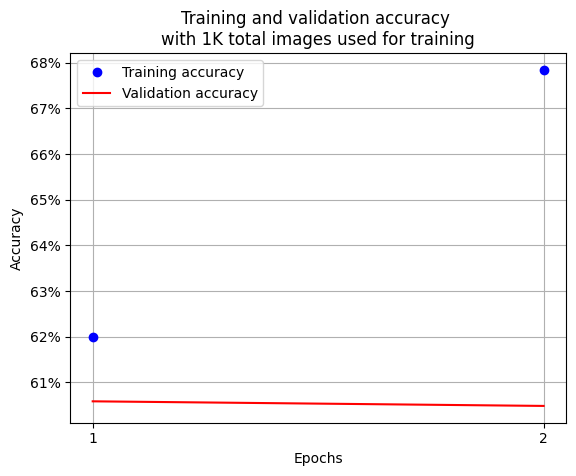

In [26]:
epochs = np.arange(2) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies_1k, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy \nwith 1K total images used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

In [27]:
from torch.utils.data import DataLoader, Dataset


class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder + "/cats/*.jpg")
    dogs = glob(folder + "/dogs/*.jpg")
    self.fpaths = cats[:1000] + dogs[:1000]
    from random import shuffle, seed

    seed(10)
    shuffle(self.fpaths)
    self.targets = [
      fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths
    ]  # dog=1 & cat=0

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = cv2.imread(f)[:, :, ::-1]
    im = cv2.resize(im, (224, 224))
    return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
      [target]
    ).float().to(device)

In [28]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [29]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_2k = [], []
for epoch in range(2):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    # print(ix)
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
    # validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  # val_losses.append(validation_loss)
  val_accuracies_2k.append(val_epoch_accuracy)

0
1


/var/folders/_9/xdt1l8b142z4_h7d1snnr5440000gn/T/ipykernel_44313/4057028039.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


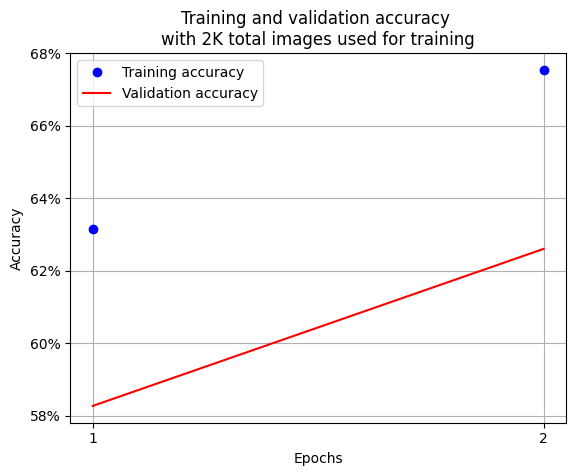

In [30]:
epochs = np.arange(2) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies_2k, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy \nwith 2K total images used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset


class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder + "/cats/*.jpg")
    dogs = glob(folder + "/dogs/*.jpg")
    self.fpaths = cats[:2000] + dogs[:2000]
    from random import shuffle, seed

    seed(10)
    shuffle(self.fpaths)
    self.targets = [
      fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths
    ]  # dog=1 & cat=0

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = cv2.imread(f)[:, :, ::-1]
    im = cv2.resize(im, (224, 224))
    return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
      [target]
    ).float().to(device)

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_4k = [], []
for epoch in range(2):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    # print(ix)
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
    # validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  # val_losses.append(validation_loss)
  val_accuracies_4k.append(val_epoch_accuracy)

In [ ]:
epochs = np.arange(2) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies_4k, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy \nwith 4K total images used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

In [ ]:
epochs = np.arange(2) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, val_accuracies_1k, "bo", label="1k data points")
plt.plot(epochs, val_accuracies_2k, "x", label="2k data points")
plt.plot(epochs, val_accuracies_4k, "--", label="4k data points", markersize=20)
plt.plot(epochs, val_accuracies, "r", label="8k data points")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(
  "Training and validation accuracy with \ndifferent number of data points used for training"
)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()